In [1]:
import dlib
import numpy as np
from PIL import Image as IMG
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch

In [2]:
def RGB2Gray(imgarr):
    LenFormat = imgarr.shape[-1]
    x = imgarr.astype('float')
    Gray = np.floor((x[:,:,0]*0.299 + \
            x[:,:,1]*0.587 + \
            x[:,:,2]*0.114) \
           * (x[:,:,3]/255.0 if LenFormat == 4
           else 1.0)).astype('uint8')
    return Gray

In [3]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('D:\\Programming\\Dlib\\shape_predictor_68_face_landmarks.dat')

In [4]:
img1 = IMG.open('../Bank1/DANSet/71.jpg')
imgarr1 = np.array(img1)
gray1 = RGB2Gray(imgarr1)

In [5]:
im_size = tuple(gray1.shape)

In [6]:
im_size

(783, 550)

In [7]:
det1 = detector(gray1)

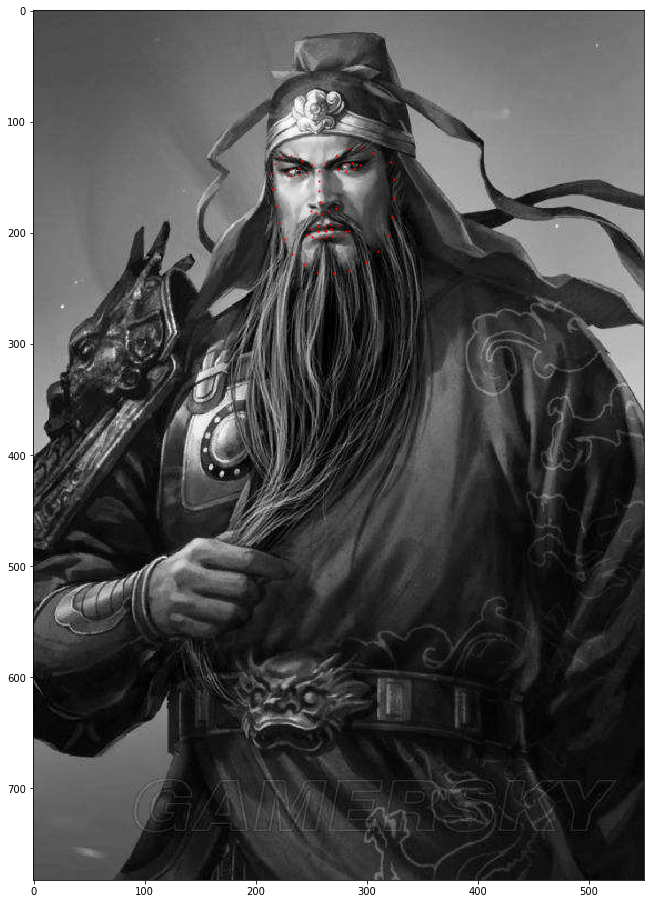

In [8]:
MFig = plt.figure(figsize=[16,16])

pts_x = []
pts_y = []
for index,face in enumerate(det1):
    shape = predictor(gray1, face)
    for index, pt in enumerate(shape.parts()):
        pts_x.append(pt.x)
        pts_y.append(pt.y)
        
plt.imshow(gray1,'gray')
plt.plot(pts_x,pts_y,'rs',MarkerSize=1) 
plt.show()

In [9]:
from scipy.spatial import Delaunay
from copy import copy

In [10]:
Points = []
for index,face in enumerate(det1):
    shape = predictor(gray1, face)
    for index, pt in enumerate(shape.parts()):
        Points.append([pt.x,pt.y])


In [11]:
delaunay_Tri = Delaunay(Points).simplices.copy()

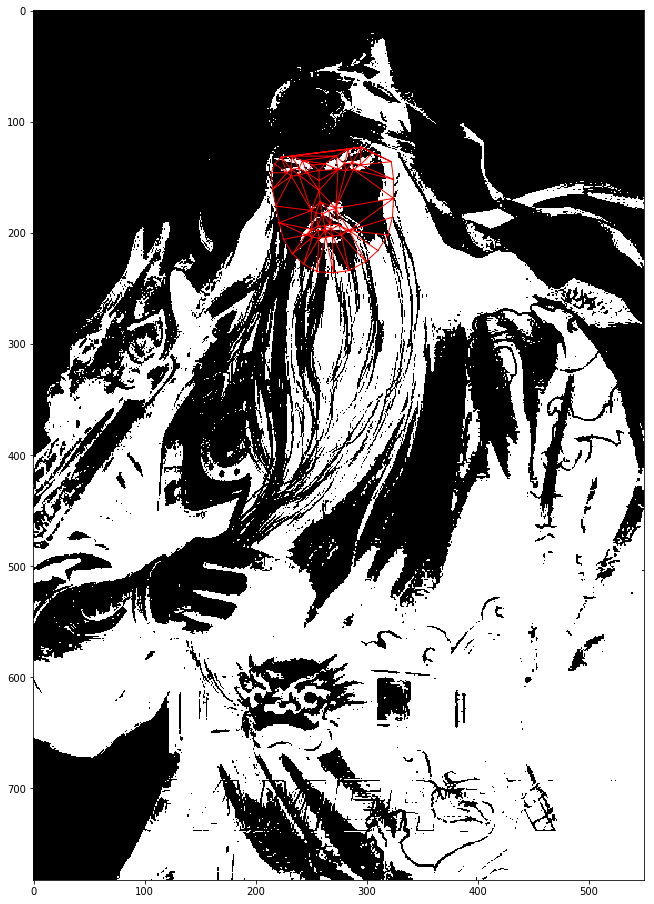

In [12]:
MFig = plt.figure(figsize=[16,16])
plt.imshow((gray1<50).astype('uint8')*255,'gray')
plt.triplot(pts_x, pts_y, delaunay_Tri, linewidth=1,color='r')
plt.show()

In [13]:
Eye_L_Low = Points[36:42]
Eye_R_Low = Points[42:48]

In [14]:
def Get_IntepPixel(Pts, FigArray):
    x_l = np.floor(Pts[0])
    x_h = x_l + 1
    y_l = np.floor(Pts[1])
    y_h = y_l + 1
    p11 = FigArray[(int)(x_l)][(int)(y_l)]
    p12 = FigArray[(int)(x_l)][(int)(y_h)]
    p21 = FigArray[(int)(x_h)][(int)(y_l)]
    p22 = FigArray[(int)(x_h)][(int)(y_h)]
    return (int)((p11*(2-Pts[0]-Pts[1]+x_l+y_l) + \
            p12*(2-Pts[0]+Pts[1]+x_l-y_h) + \
            p21*(2+Pts[0]-Pts[1]-x_h+y_l) + \
            p22*(2+Pts[0]+Pts[1]-x_h-y_h))/2)

In [15]:
boarder1 = (gray1<50).astype('uint8')*255

In [16]:
MaxStep = 4
Eye_L_High = []
Step = 1

EyeCenter = np.array([0,0],dtype='float32')
for p in Eye_L_Low:
    EyeCenter[0] += p[0]
    EyeCenter[1] += p[1]
EyeCenter /= len(Eye_L_Low)

# Corners
ep = np.array(Eye_L_Low[0],dtype='float32')
DIR = np.array([ep[0]-EyeCenter[0],ep[1]-EyeCenter[1]],dtype='float32')
DIR = DIR/np.linalg.norm(DIR)
Eye_L_High.append([6,DIR])

# upper side
ep = np.array(Eye_L_Low[1],dtype='float32')
DIR = np.array([0,-1],dtype='float32')
Eye_L_High.append([4,DIR])

ep = np.array(Eye_L_Low[2],dtype='float32')
DIR = np.array([0,-1],dtype='float32')
Eye_L_High.append([4,DIR])

# Corners
ep = np.array(Eye_L_Low[3],dtype='float32')
DIR = np.array([ep[0]-EyeCenter[0],ep[1]-EyeCenter[1]],dtype='float32')
DIR = DIR/np.linalg.norm(DIR)
Eye_L_High.append([4,DIR])


In [17]:
MaxStep = 10
Eye_R_High = []
Step = 1

EyeCenter = np.array([0,0],dtype='float32')
for p in Eye_R_Low:
    EyeCenter[0] += p[0]
    EyeCenter[1] += p[1]
EyeCenter /= len(Eye_R_Low)

# Corners
ep = np.array(Eye_R_Low[0],dtype='float32')
DIR = np.array([ep[0]-EyeCenter[0],ep[1]-EyeCenter[1]],dtype='float32')
DIR = DIR/np.linalg.norm(DIR)
Eye_R_High.append([4,DIR])

# upper side
ep = np.array(Eye_R_Low[2],dtype='float32')
DIR = np.array([0,-1],dtype='float32')
Eye_R_High.append([4,DIR])

ep = np.array(Eye_R_Low[1],dtype='float32')
DIR = np.array([0,-1],dtype='float32')
Eye_R_High.append([4,DIR])

# Corners
ep = np.array(Eye_R_Low[3],dtype='float32')
DIR = np.array([ep[0]-EyeCenter[0],ep[1]-EyeCenter[1]],dtype='float32')
DIR = DIR/np.linalg.norm(DIR)
Eye_R_High.append([6,DIR])

In [18]:
# face
Face_Out = list(copy(p) for p in Points[0:17])
FaceCenter = np.array([0,0],dtype='float32')
for p in Face_Out:
    FaceCenter[0] += p[0]
    FaceCenter[1] += p[1]
FaceCenter /= len(Face_Out)

out_size = 10
for i in range(len(Face_Out)):
    DIR = np.array([Face_Out[i][0]-FaceCenter[0],
                    Face_Out[i][1]-FaceCenter[1]],dtype='float32')
    DIR = DIR/np.linalg.norm(DIR)
    Face_Out[i][0] += out_size*DIR[0]
    Face_Out[i][1] += out_size*DIR[1]

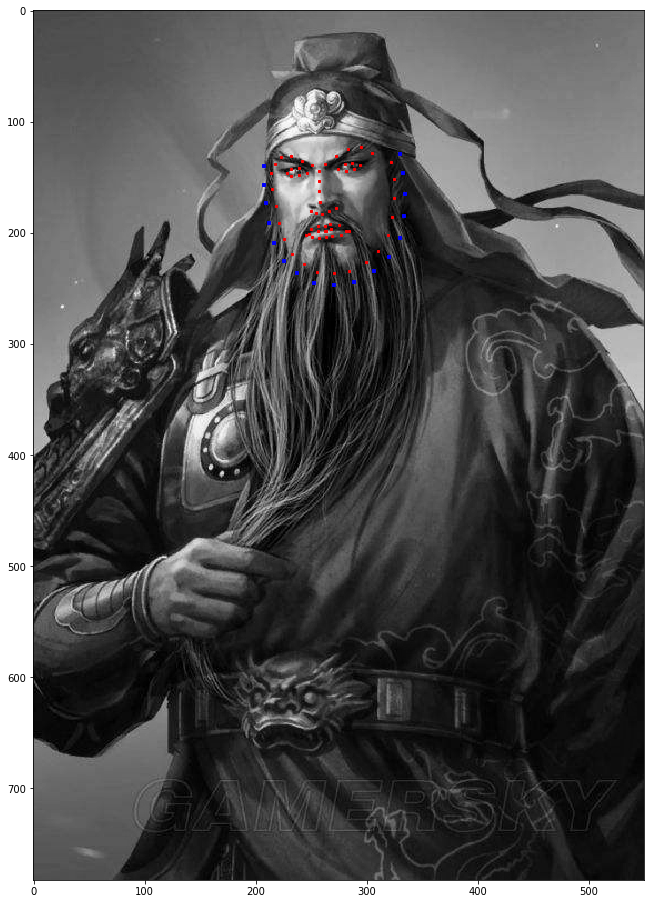

In [24]:
MFig = plt.figure(figsize=[16,16])
        
plt.imshow(gray1,'gray')
for p in Points:
    plt.plot(p[0],p[1],'rs',MarkerSize=2)

for p in Face_Out:
    plt.plot(p[0],p[1],'bs',MarkerSize=3)
plt.show()

In [45]:
def SmoothStep(x,low,high):
    if x < low:
        return 0
    elif x > high:
        return 1
    else:
        return (x-low)/(high-low)

In [59]:
# 0: Others |
# 1: head |
# 2: eye_corner | 3: eye_upper | 4: eye_lower
Final_PT = list([p[0],p[1],1,0,1] for p in Points)
Final_PT[36][2] = 2
Final_PT[39][2] = 2
Final_PT[42][2] = 2
Final_PT[45][2] = 2

U_Alpha = 0.7
D_Alpha = 1.0 - U_Alpha
Final_PT[37][2] = 3
Final_PT[37][3] = (Final_PT[41][0]-Final_PT[37][0])*U_Alpha
Final_PT[37][4] = (Final_PT[41][1]-Final_PT[37][1])*U_Alpha

Final_PT[38][2] = 3
Final_PT[38][3] = (Final_PT[40][0]-Final_PT[38][0])*U_Alpha
Final_PT[38][4] = (Final_PT[40][1]-Final_PT[38][1])*U_Alpha

Final_PT[40][2] = 4
Final_PT[40][3] = (Final_PT[38][0]-Final_PT[40][0])*D_Alpha
Final_PT[40][4] = (Final_PT[38][1]-Final_PT[40][1])*D_Alpha

Final_PT[41][2] = 4
Final_PT[41][3] = (Final_PT[37][0]-Final_PT[41][0])*D_Alpha
Final_PT[41][4] = (Final_PT[37][1]-Final_PT[41][1])*D_Alpha

Final_PT[43][2] = 3
Final_PT[43][3] = (Final_PT[47][0]-Final_PT[43][0])*U_Alpha
Final_PT[43][4] = (Final_PT[47][1]-Final_PT[43][1])*U_Alpha

Final_PT[44][2] = 3
Final_PT[44][3] = (Final_PT[46][0]-Final_PT[44][0])*U_Alpha
Final_PT[44][4] = (Final_PT[46][1]-Final_PT[44][1])*U_Alpha

Final_PT[46][2] = 4
Final_PT[46][3] = (Final_PT[44][0]-Final_PT[46][0])*D_Alpha
Final_PT[46][4] = (Final_PT[44][1]-Final_PT[46][1])*D_Alpha

Final_PT[47][2] = 4
Final_PT[47][3] = (Final_PT[43][0]-Final_PT[47][0])*D_Alpha
Final_PT[47][4] = (Final_PT[43][1]-Final_PT[47][1])*D_Alpha

# upper boarder
Face_Center = [0.0,0.0]
Face_Out_num = 0
FO_Start = len(Final_PT)
#F_Out = []
for index,face in enumerate(det1):
    FACES.append(face)
    for x in np.linspace(face.left(),face.right(),4):
        Final_PT.append([x,face.top(),1,0,1])
        Face_Center[0] += x
        Face_Center[1] += face.top()
        Face_Out_num += 1

for p in Face_Out:
    Final_PT.append([p[0],p[1],1,0,1])
    Face_Center[0] += p[0]
    Face_Center[1] += p[1]
    Face_Out_num += 1
    #F_Out.append((p[0],p[1]))

Face_Center[0] /= (float)(Face_Out_num)
Face_Center[1] /= (float)(Face_Out_num)
F_Radius = 0.0
for op in Final_PT[FO_Start:]:
    R_Temp = (op[0]-Face_Center[0])**2 + (op[1]-Face_Center[1])**2
    if R_Temp > F_Radius:
        F_Radius = R_Temp
# eye boarder
#Final_PT.append([p[0],p[1],1])

# uniform points
for x in range(0,im_size[1],20):
    if im_size[1] - x < 20:
        x = im_size[1]
    x_dist = x-Face_Center[0]
    x_shift = SmoothStep(x_dist,0,im_size[1]/2)
    for y in range(0,FACES[0].top()-20,20):
        _Dist =  x_dist**2 + (y-Face_Center[1])**2
        Final_PT.append([x,y,0,x_shift,0])
    for y in range(im_size[0],FACES[0].bottom()+20,-20):
        _Dist = x_dist**2 + (y-Face_Center[1])**2
        y_ss = 0.0
        if im_size[0] - y < 64:
            y_ss = 1.0 - SmoothStep(im_size[0] - y,0,64)
        else:
            y_ss = SmoothStep(_Dist,0,400)
            
        Final_PT.append([x,y,0,x_shift,y_ss])

for y in range(FACES[0].top(),FACES[0].bottom(),20):
    y_dist = (y-Face_Center[1])**2
    for x in range(0,FACES[0].left()-20,20):
        x_dist = (x-Face_Center[0])**2
        x_shift = SmoothStep(x_dist,F_Radius,(im_size[1]**2)/4)
        _Dist = x_dist + y_dist
        Final_PT.append([x,y,0,-x_shift,SmoothStep(_Dist,0,400)])
    for x in range(im_size[1],FACES[0].right()+20,-20):
        x_dist = (x-Face_Center[0])**2
        x_shift = SmoothStep(x_dist,F_Radius,(im_size[1]**2)/4)
        _Dist = x_dist + y_dist
        Final_PT.append([x,y,0,x_shift,SmoothStep(_Dist,0,400)])
        


In [57]:
# Triangulation
delaunay_Tri = Delaunay(list([p[0],p[1]] for p in Final_PT)).simplices.copy()

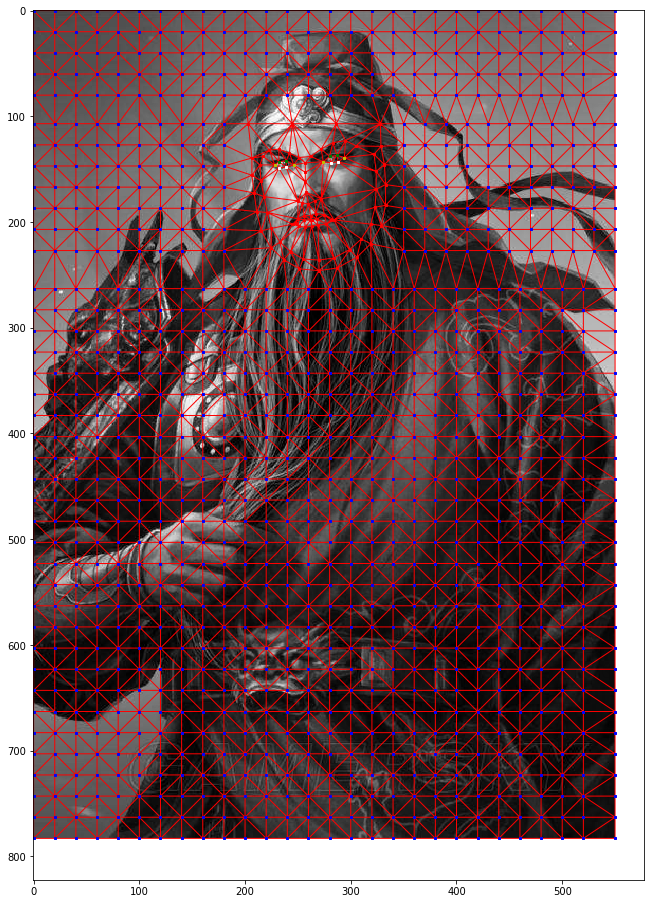

In [48]:
MFig = plt.figure(figsize=[16,16])
C_DICT = {
    0:'b',
    1:'r',
    2:'y',
    3:'g',
    4:'white'
}
plt.imshow(gray1,'gray')
ptx=[]
pty=[]
for p in Final_PT:
    plt.plot(p[0],p[1],marker='s',MarkerSize=2,color=C_DICT[p[2]])
    ptx.append(p[0])
    pty.append(p[1])
plt.triplot(ptx, pty, delaunay_Tri, linewidth=1,color='r')
plt.show()

In [58]:
FW = open('HM_71.json','w')
FW.write('#,%i,%i\n'%(len(Final_PT),len(delaunay_Tri)))

for p in Final_PT:
    line = '%.3f,%.3f,%.3f,%.3f,%i,%.3f,%.3f\n'%\
    ((float)(p[0])/(float)(im_size[1])*((float)(im_size[1])/im_size[0]),(float)(p[1])/(float)(im_size[0]),
     (float)(p[0])/(float)(im_size[1]),1.0 - (float)(p[1])/(float)(im_size[0]),
     p[2],
     p[3],p[4])
    FW.write(line)

for Tri in delaunay_Tri:
    line = '%i,%i,%i\n'%(Tri[0],Tri[1],Tri[2])
    FW.write(line)
FW.close()